In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import timedelta
import plotly.express as px

Сначала смотрю на данные, перевожу секунды в читаемый формат и объединяю две таблицы для построения коготр и дальнейшего анализа

In [3]:
#Таблица с данными о времени регистрации пользователей
reg_df = pd.read_csv('~/shared/problem1-reg_data.csv', sep=';')

In [4]:
reg_df.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [5]:
#Перевела время в читаемый формат даты
reg_df['reg_time'] = pd.to_datetime(reg_df['reg_ts'], unit='s').dt.strftime('%Y-%m-%d')

In [6]:
reg_df.head()

,reg_ts,uid,reg_time
0,911382223,1,1998-11-18
1,932683089,2,1999-07-22
2,947802447,3,2000-01-13
3,959523541,4,2000-05-28
4,969103313,5,2000-09-16


In [7]:
reg_df.shape

(1000000, 3)

In [8]:
reg_df.dtypes

reg_ts       int64
uid          int64
reg_time    object
dtype: object

In [9]:
reg_df.uid.nunique()

1000000

In [10]:
#Таблица с данными о времени захода пользователей в игру
game_df = pd.read_csv('~/shared/problem1-auth_data.csv', sep=';')

In [11]:
game_df.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [12]:
#Перевела время в читаемый формат даты
game_df['game_time'] = pd.to_datetime(game_df['auth_ts'], unit='s').dt.strftime('%Y-%m-%d')

In [13]:
game_df.head()

,auth_ts,uid,game_time
0,911382223,1,1998-11-18
1,932683089,2,1999-07-22
2,932921206,2,1999-07-25
3,933393015,2,1999-07-31
4,933875379,2,1999-08-05


In [14]:
game_df.shape

(9601013, 3)

In [15]:
game_df.dtypes

auth_ts       int64
uid           int64
game_time    object
dtype: object

In [16]:
game_df.uid.nunique()

1000000

In [17]:
#Объединила обе таблицы
df = game_df.merge(reg_df, how='left', on='uid')

In [18]:
#Оставила три колонки
df = df[['uid', 'reg_time', 'game_time']]

In [19]:
df.head()

,uid,reg_time,game_time
0,1,1998-11-18,1998-11-18
1,2,1999-07-22,1999-07-22
2,2,1999-07-22,1999-07-25
3,2,1999-07-22,1999-07-31
4,2,1999-07-22,1999-08-05


In [20]:
df.shape

(9601013, 3)

In [21]:
df.uid.nunique()

1000000

In [22]:
df['reg_time'].min()

'1998-11-18'

In [23]:
df['reg_time'].max()

'2020-09-23'

In [24]:
df['game_time'].min()

'1998-11-18'

In [25]:
df['game_time'].max()

'2020-09-23'

Данные в таблице представлены за очень большой период, поэтому строить когорты по всем дням нерационально. Думаю, будет разумно устанавливать вручную дни начала и окончания retention анализа

In [26]:
#Для примера беру следующие даты: 01.05.2020 - 15.05.2020

df_example = df.query('reg_time >= "2020-05-01" and game_time <= "2020-05-15"')

In [27]:
# Посчитала количество уникальных пользователей по периодам регистрации и периодам игр
df_example = df_example.groupby(['reg_time', 'game_time'], as_index=False) \
    .agg({'uid': 'nunique'}) \
    .sort_values(['reg_time', 'game_time'])

In [28]:
df_example.head()

,reg_time,game_time,uid
0,2020-05-01,2020-05-01,1295
1,2020-05-01,2020-05-02,20
2,2020-05-01,2020-05-03,51
3,2020-05-01,2020-05-04,59
4,2020-05-01,2020-05-05,64


In [29]:
# Создала колонку с данными о количестве пользователей на начало каждого когортого периода
df_example.set_index('reg_time', inplace=True)
df_example['number_of_users_per_cohort'] = df_example.groupby(level=0).uid.max()
df_example.reset_index(inplace=True)

In [30]:
df_example.head()

,reg_time,game_time,uid,number_of_users_per_cohort
0,2020-05-01,2020-05-01,1295,1295
1,2020-05-01,2020-05-02,20,1295
2,2020-05-01,2020-05-03,51,1295
3,2020-05-01,2020-05-04,59,1295
4,2020-05-01,2020-05-05,64,1295


In [31]:
# Посчитала доли пользователей по когортным периодам
df_example['retention'] = (df_example['uid'] / df_example['number_of_users_per_cohort']).round(2)

In [32]:
df_example.head()

,reg_time,game_time,uid,number_of_users_per_cohort,retention
0,2020-05-01,2020-05-01,1295,1295,1.00
1,2020-05-01,2020-05-02,20,1295,0.02
2,2020-05-01,2020-05-03,51,1295,0.04
3,2020-05-01,2020-05-04,59,1295,0.05
4,2020-05-01,2020-05-05,64,1295,0.05


In [33]:
# Для удобства создала колонку с номером периода для каждой когортной группы
df_example['cohort_period']=df_example.groupby('reg_time').cumcount()+1

In [34]:
df_example.head()

,reg_time,game_time,uid,number_of_users_per_cohort,retention,cohort_period
0,2020-05-01,2020-05-01,1295,1295,1.00,1
1,2020-05-01,2020-05-02,20,1295,0.02,2
2,2020-05-01,2020-05-03,51,1295,0.04,3
3,2020-05-01,2020-05-04,59,1295,0.05,4
4,2020-05-01,2020-05-05,64,1295,0.05,5


In [35]:
# Создала сводную таблицу, где индексы - номера когортного периода, колонки - когортные группы, значения - доля пользователей
df_example = df_example.pivot_table(index='cohort_period', columns='reg_time', values='retention')

In [36]:
df_example

reg_time,2020-05-01,2020-05-02,2020-05-03,2020-05-04,2020-05-05,2020-05-06,2020-05-07,2020-05-08,2020-05-09,2020-05-10,2020-05-11,2020-05-12,2020-05-13,2020-05-14,2020-05-15
cohort_period,,,,,,,,,,,,,,,
1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0
2,0.02,0.02,0.01,0.02,0.01,0.02,0.02,0.02,0.03,0.02,0.02,0.01,0.03,0.03,NaN
3,0.04,0.04,0.05,0.04,0.04,0.04,0.05,0.04,0.04,0.04,0.03,0.05,0.03,NaN,NaN
4,0.05,0.04,0.04,0.05,0.04,0.05,0.05,0.05,0.05,0.05,0.05,0.04,NaN,NaN,NaN
5,0.05,0.06,0.06,0.06,0.04,0.04,0.05,0.05,0.06,0.06,0.06,NaN,NaN,NaN,NaN
6,0.06,0.06,0.05,0.07,0.06,0.06,0.06,0.05,0.05,0.05,NaN,NaN,NaN,NaN,NaN
7,0.08,0.06,0.07,0.07,0.06,0.08,0.06,0.07,0.06,NaN,NaN,NaN,NaN,NaN,NaN
8,0.06,0.06,0.07,0.06,0.06,0.06,0.07,0.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.05,0.05,0.06,0.05,0.05,0.06,0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


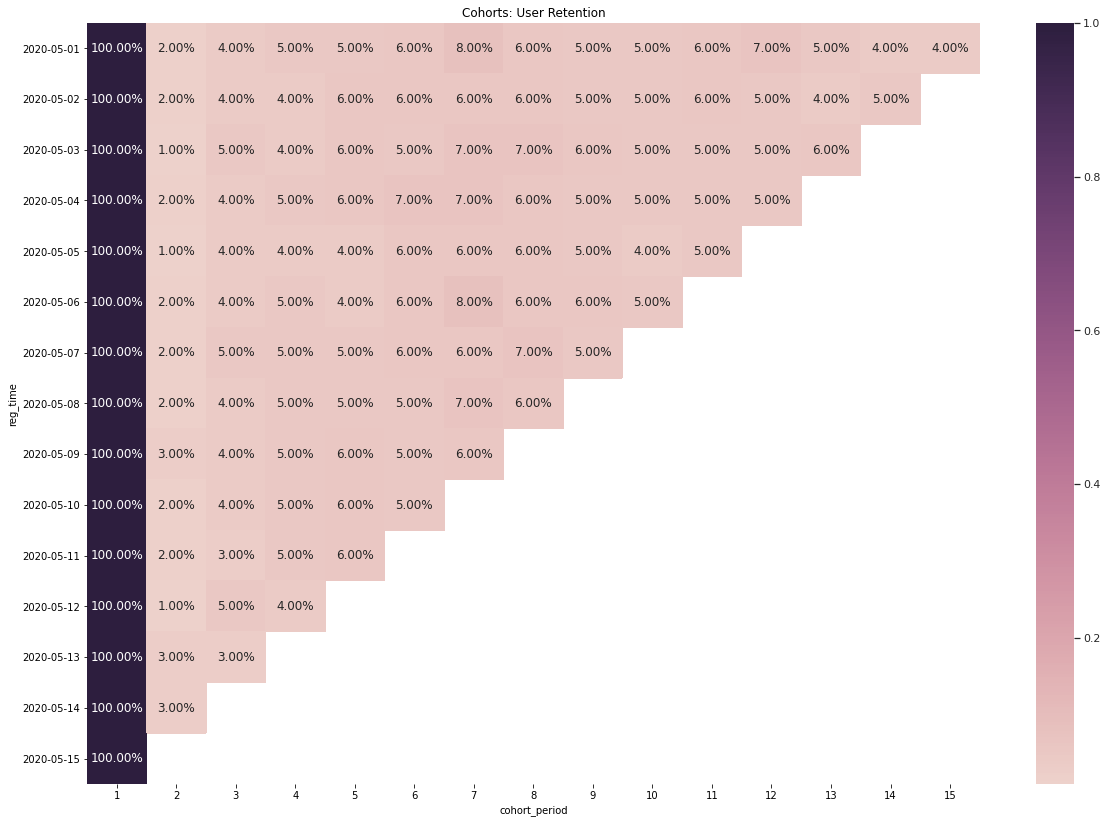

In [37]:
# Визуализация с помощью heatmap
plt.figure(figsize=(20, 14))
plt.title('Cohorts: User Retention')
sns.set(style='white')
sns.heatmap(df_example.T, mask=df_example.T.isnull(), annot=True, cmap=sns.cubehelix_palette(as_cmap=True), fmt='.2%')

## Функция для расчета retention по предварительно определенному периоду

In [38]:
#Функция, которая считывает таблицы, преобразует ts, объединяет таблицы:
def preparation():
    reg_df = pd.read_csv('~/shared/problem1-reg_data.csv', sep=';')
    reg_df['reg_time'] = pd.to_datetime(reg_df['reg_ts'], unit='s').dt.strftime('%Y-%m-%d')
    game_df = pd.read_csv('~/shared/problem1-auth_data.csv', sep=';')
    game_df['game_time'] = pd.to_datetime(game_df['auth_ts'], unit='s').dt.strftime('%Y-%m-%d')
    df = game_df.merge(reg_df, how='left', on='uid')
    df = df[['uid', 'reg_time', 'game_time']]
    return df

In [ ]:
# Дата начала анализа (формат "ГГГГ-ММ-ДД")
first_date = 
# Дата окончания анализа (формат "ГГГГ-ММ-ДД")
last_date = 

In [ ]:
#Функция, которая возвращает таблицу:
def retention_table(df, first_date, last_date):
    df = df.query('reg_time >= @first_date and game_time <= @last_date')
    
    df = df.groupby(['reg_time', 'game_time'], as_index=False) \
    .agg({'uid': 'nunique'}) \
    .sort_values(['reg_time', 'game_time'])
    
    df.set_index('reg_time', inplace=True)
    df['number_of_users_per_cohort'] = df.groupby(level=0).uid.max()
    df.reset_index(inplace=True)
    
    df['retention'] = (df['uid'] / df['number_of_users_per_cohort']).round(2)
    
    df['cohort_period']=df.groupby('reg_time').cumcount()+1
    
    retention_table = df.pivot_table(index='cohort_period', columns='reg_time', values='retention')
    
    return retention_table

In [ ]:
#Функция, которая возвращает тепловую карту:

def retention_viz(df, first_date, last_date):
    df = df.query('reg_time >= @first_date and game_time <= @last_date')
    
    df = df.groupby(['reg_time', 'game_time'], as_index=False) \
    .agg({'uid': 'nunique'}) \
    .sort_values(['reg_time', 'game_time'])
    
    df.set_index('reg_time', inplace=True)
    df['number_of_users_per_cohort'] = df.groupby(level=0).uid.max()
    df.reset_index(inplace=True)
    
    df['retention'] = (df['uid'] / df['number_of_users_per_cohort']).round(2)
    
    df['cohort_period']=df.groupby('reg_time').cumcount()+1
    
    retention_table = df.pivot_table(index='cohort_period', columns='reg_time', values='retention')
    
    plt.figure(figsize=(20, 14))
    plt.title('Cohorts: User Retention')
    sns.set(style='white')
    sns.heatmap(retention_table.T, mask=retention_table.T.isnull(), annot=True, cmap=sns.cubehelix_palette(as_cmap=True), fmt='.2%')
    return sns.heatmap

In [ ]:
retention_viz(df, first_date, last_date)